In [32]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from torch.nn.functional import interpolate

from sklearn.preprocessing import StandardScaler

if '__file__' in globals():
    script_dir = os.path.dirname(__file__)
else:
    script_dir = os.getcwd()
sys.path.append(os.path.join(script_dir, './'))

from utils.sokoto_dataset import SOKOTODataset
from utils.polyu_dataset import PolyUDatasetContactless
from utils.pca_module import pca_data_construction, pca_generation, pca_collate_fn

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Sokoto

In [63]:
size = (96, 108)

train_transform = transforms.Compose([
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize(size),
    transforms.Normalize((0.5), (1.0)),
])

scoofing_db = "./../images/SCOOF_DB/SOCOFing/Real"
labels_file="./metadata/sokoto_meta.txt"
sokoto_dataset = SOKOTODataset(root_dir=scoofing_db, labels_file=labels_file, transform=train_transform)

pca_elements = 784

x, _ = pca_data_construction(sokoto_dataset)
_, sokoto_pca_model, _, scaler = pca_generation(x, StandardScaler(), pca_elements)

Sum of variance explained by top 784 components: 80.92%


# PolyU

In [109]:
size = (350, 225)

train_transform = transforms.Compose([
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0)),
])

polyu_location = "./../images/Cross_Fingerprint_Images_Database/processed_contactless_2d_fingerprint_images"
polyu_dataset = PolyUDatasetContactless(root_dir=polyu_location, type='train', transform=train_transform)

pca_elements = 784

x, _ = pca_data_construction(polyu_dataset)
_, polyu_pca_model, _, scaler = pca_generation(x, StandardScaler(), pca_elements)

Sum of variance explained by top 784 components: 98.00%


Explained variance (PolyU): 0.97997177
Explained variance (Sokoto): 0.80920976


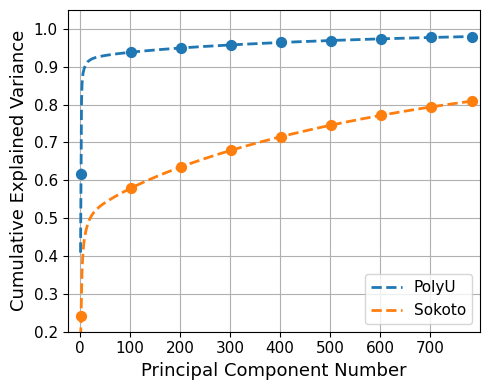

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Compute cumulative explained variance
cumulative_var_polyu = np.cumsum(polyu_pca_model.explained_variance_ratio_)
cumulative_var_sokoto = np.cumsum(sokoto_pca_model.explained_variance_ratio_)

print("Explained variance (PolyU):", cumulative_var_polyu[-1])
print("Explained variance (Sokoto):", cumulative_var_sokoto[-1])

x = np.arange(1, len(cumulative_var_polyu) + 1)

plt.figure(figsize=(5, 4))

# Line without markers
plt.plot(x, cumulative_var_polyu, linestyle='--', linewidth=2, label='PolyU')
plt.plot(x, cumulative_var_sokoto, linestyle='--', linewidth=2, label='Sokoto')

step = 100

ticks = np.arange(0, len(cumulative_var_polyu), step)

plt.xticks(ticks)

# Add dots every 10 points (change step to 5 if you prefer)
indexes = x[::step]
# add one to the end
indexes = np.append(indexes, x[-1] -1)
plt.scatter(indexes, cumulative_var_polyu[indexes], s=50, zorder=3)
plt.scatter(indexes, cumulative_var_sokoto[indexes], s=50, zorder=3)

# Labels and title
# plt.title('Cumulative Explained Variance by Principal Component', fontsize=14)
plt.xlabel('Principal Component Number', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.grid(True)
plt.ylim(0.2, 1.05)
plt.xlim(-25, 800)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
# plt.show()

plt.savefig('pca_explained_variance.pdf', dpi=300)

# Setup dataloader to automatically use collate function

In [107]:
pca_transform = lambda batch: pca_collate_fn(
    batch,
    sokoto_pca_model,
    scaler,
    size,
    return_components=False
)

In [108]:
normal_img, label = polyu_dataset[0]

NameError: name 'polyu_dataset' is not defined

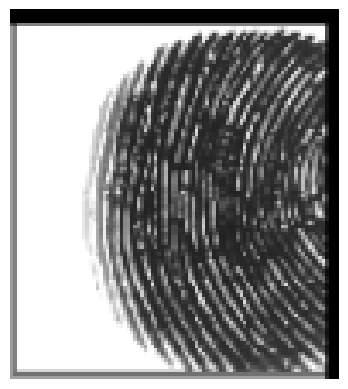

In [ ]:
#  Remove axis titles and save as png
out = normal_img[0].cpu().numpy().T
# flip out
out = np.flipud(out)
plt.imshow(out, cmap='gray')
# flip
plt.axis('off')
plt.savefig('polyu_pca_visualization_before.pdf', bbox_inches='tight', pad_inches=0)

0.009610891342163086


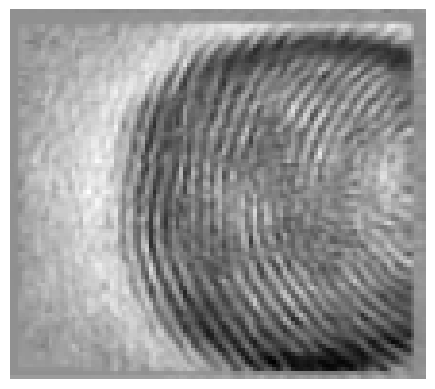

In [ ]:
import time
start_time = time.time()
pca_img = pca_transform([(normal_img, label)])
print(time.time()-start_time)
pca_img = pca_img[0][0][0].cpu()

# interpolate to the transpose of size
pca_img_resized = interpolate(pca_img.unsqueeze(0).unsqueeze(0), size=(size[1], size[0]), mode='bilinear', align_corners=False).squeeze().numpy()


out = pca_img_resized.T
out = np.flipud(out)
plt.imshow(out, cmap='gray')
plt.axis('off')
plt.savefig('polyu_pca_visualization_after.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
pca_transform = lambda batch: pca_collate_fn(
    batch,
    sokoto_pca_model,
    scaler,
    size,
    return_components=False
)

In [ ]:
normal_img, label = sokoto_dataset[100]

(96, 108)


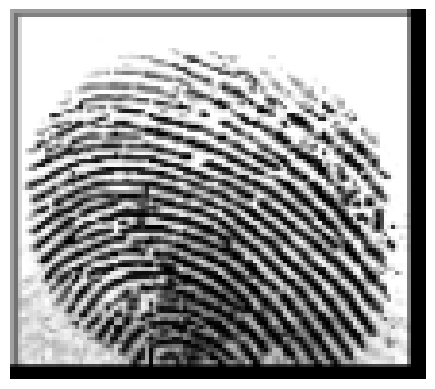

In [ ]:
#  Remove axis titles and save as png
out = normal_img[0].cpu().numpy()
print(out.shape)
plt.imshow(out, cmap='gray')
# flip
plt.axis('off')
plt.savefig('sokoto_pca_visualization_before.pdf', bbox_inches='tight', pad_inches=0)

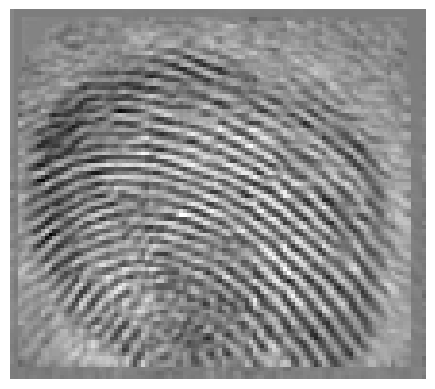

In [ ]:
import time
start_time = time.time()
pca_img = pca_transform([(normal_img, label)])
out = pca_img[0][0][0].cpu()

plt.imshow(out, cmap='gray')
plt.axis('off')
plt.savefig('sokoto_pca_visualization_after.pdf', bbox_inches='tight', pad_inches=0)